## Comparing Combat controls and PTSD
- Here we are using Inter-Subject correlation to compare combat controls and PTSD while watching a movie clip (from Platoon). The clip starts slow and around the middle begin to be intensive

In [1]:
## Using the brainiak tutorial for ISC and group comparison
## https://brainiak.org/tutorials/10-isc/
%config Completer.use_jedi = False

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time

import numpy as np
import pandas as pd 
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker

from brainiak import image, io
from brainiak.isc import isc, bootstrap_isc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 
from nltools.stats import fdr, threshold
from nltools import Brain_Data
%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 30 seconds


In [4]:
#Do voxelwise
groups = pd.read_csv('/home/oad4/RCF_Movies/naturalistic_analysis/cleanPCL.csv')
subj_list = groups["subject"]
data_dir = '/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/results/voxelwiseTS/'
data = {}
# need to stratify to a few parts(because files are huge)
# grab shape of matrix from one subject

#cut_point = 110000 # approximately half
def getPart(subj_list, x_num, nSplits):
    # split array and return relevant number of splits 
    for subj in subj_list:
        time_series_fname = os.path.join(data_dir, f'{subj}_ses-3_voxelWiseGM.npy')
        time_series = np.load(time_series_fname)
        time_series = time_series[5:1010,:]
        # now split array (on column axis) as number of requested splits
        time_series_split = np.array_split(time_series, nSplits, axis=1)
        data[subj] = time_series_split[x_num] # return relevant part of array
    return list(data.values())

In [5]:
group_assignment = np.array(groups.group.eq('PTSD').mul(1))
group_assignment

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1])

In [ ]:
# lets just take first part
# grab data
# go through ISC per voxel
# stratify to groups
# combine all voxels
# run permutation

In [51]:
# for loop running through stratification (10 parts) of the entire brain voxels and building a map
isc_maps_all = {}
for i in range(10):
    print(i)
    name = 'isc_maps' + str(i+1)
    print(name)
    isc_maps_all[name] = isc(getPart(subj_list, i, 10), pairwise=False)

0
isc_maps1
1
isc_maps2
2
isc_maps3
3
isc_maps4
4
isc_maps5
5
isc_maps6
6
isc_maps7
7
isc_maps8
8
isc_maps9
9
isc_maps10


In [55]:
## need to hstack everything back to subjects X voxels ISC map

isc_maps_all_voxels = np.hstack([isc_maps_all[task_name] for
                                task_name in isc_maps_all])
# run permutation test

In [7]:
# save array for future analysis

#np.save('isc_maps_all_voxels', isc_maps_all_voxels)
# load isc maps array
isc_maps_all_voxels = np.load('isc_maps_all_voxels.npy')
print(isc_maps_all_voxels.shape)

(41, 229007)


In [68]:
# first, lets look at both groups and see whats going on
# we bootstrap
observed, ci, p, distribution = bootstrap_isc(isc_maps_all_voxels, pairwise=False, n_bootstraps=5000)

In [10]:
# turn to nifti
group_mask = '/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/results/grayMatter_maskRCFmovies.nii.gz'
masker = NiftiMasker(group_mask).fit()

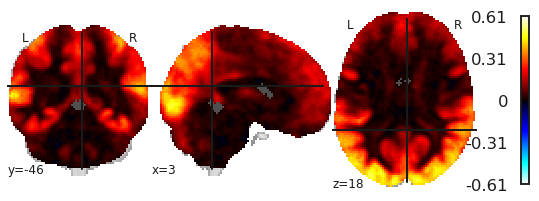

In [69]:
image = masker.inverse_transform(observed)
pBrain = masker.inverse_transform(p)
plotting.plot_stat_map(image)

In [79]:
# threshold
thr = fdr(p)
print(thr)
imageB = Brain_Data(masker.inverse_transform(observed))
imageP = Brain_Data(masker.inverse_transform(p))
fdrImage = threshold(imageB, imageP, thr=thr).to_nifti()
fdrImage.to_filename('bothGroups_fdrCorrected.nii.gz')

0.04539092181563687


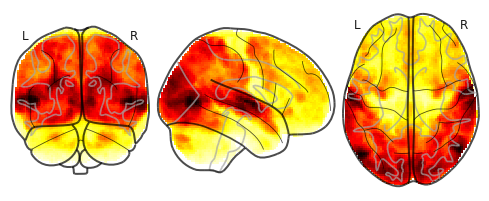

In [78]:
plotting.plot_glass_brain(fdrImage)

In [ ]:
# permutation testing - to test differences between groups

n_permutations = 1000
summary_statistic='mean'

observed, p, distribution = permutation_isc(
    isc_maps_all_voxels, 
    pairwise=False,
    group_assignment=group_assignment, 
    side = 'two-sided',
    summary_statistic=summary_statistic,
    n_permutations=n_permutations
)

p = p.ravel()
observed = observed.ravel()

print('observed:{}'.format(np.shape(observed)))
print('p:{}'.format(np.shape(p)))
print('distribution: {}'.format(np.shape(distribution)))

In [ ]:
#threshold (fdr)
thr = fdr(p, q=0.05)
p

In [ ]:
# get it in text
obThr = np.array(observed)
obThr[p>thr] = 0
# get index location of non zero values
np.where(obThr)[0]

In [ ]:
obThr

In [ ]:
plotting.plot_img_on_surf(threshold(isc_r_brain, isc_p_brain, thr=thr).to_nifti(),
                                  views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          colorbar=True, threshold = 0.00001)

In [ ]:
# save thresholded image
image = threshold(isc_r_brain, isc_p_brain, thr=thr).to_nifti()
d = Brain_Data(image)
d.write("GroupComp_allMovie_FDRCorr_200ROI.nii.gz")

In [ ]:
plotting.view_img(image)

In [ ]:
plt.figure(figsize=(10,10))
plotting.plot_stat_map(image, display_mode='mosaic')

## What if we make up groups?
- We randomize group assignment and then permute them

In [ ]:
ptsd_listR = ptsd_list[0:8] + cc_list[0:12]
cc_listR = ptsd_list[9:] + cc_list[13:]
groupPT_r = [1] * len(ptsd_listR)
groupCC_r = [0] * len(cc_listR)
groupsR = np.concatenate([groupPT_r, groupCC_r])
bothR = {'ptsdR': ptsd_listR, 'ccR':cc_listR}

In [ ]:
# run ISC, loop over conditions 
isc_mapsR = {}
for task_name in bothR:
    print(task_name)
    isc_mapsR[task_name] = isc(bothR[task_name], pairwise=False)
    print('Shape of %s condition:' % task_name, np.shape(isc_mapsR[task_name]))

In [ ]:
# Concatenate ISCs from both tasks
isc_maps_all_tasksR = np.vstack([isc_mapsR[task_name] for
                                task_name in bothR])

print('group_assignment: {}'.format(groupsR))
print('isc_maps_all_tasks: {}' .format(np.shape(isc_maps_all_tasks)))

In [ ]:
# permutation testing
n_permutations = 50000
summary_statistic='mean'

observedR, pR, distributionR = permutation_isc(
    isc_maps_all_tasksR, 
    pairwise=False,
    group_assignment=groupsR, 
    side = 'two-sided',
    summary_statistic=summary_statistic,
    n_permutations=n_permutations
)

pR = p.ravel()
observedR = observed.ravel()

print('observed:{}'.format(np.shape(observedR)))
print('p:{}'.format(np.shape(pR)))
print('distribution: {}'.format(np.shape(distributionR)))

In [ ]:
isc_r_brainR, isc_p_brainR = roi_to_brain(pd.Series(observedR), mask_x), roi_to_brain(pd.Series(pR), mask_x)

In [ ]:
thrR = fdr(pR)
thrR

In [ ]:
plotting.plot_stat_map(threshold(isc_r_brainR, isc_p_brainR, thr=thrR).to_nifti(), display_mode='mosaic')